# 计算V/T模型三次运行结果的平均指标

本 notebook 用于计算三次独立运行（**不同 fold**）的平均指标，包括：
- 总体准确率（Test ACC）
- 每个表情类别的 Precision、Recall、F1-score
- Macro avg 和 Weighted avg 指标

In [80]:
# ===== GPU 配置（防止内存溢出）=====
import os
import tensorflow as tf
# ===== GPU 配置结束 =====

import gc
import numpy as np
import pickle
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("库导入成功！")

库导入成功！


In [81]:
# ========== 加载数据函数 ==========
def load_features(file_path):
    """加载特征文件"""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [82]:
# ========== 配置 ==========
# 三个模型的路径和 fold 编号
model_configs = [
    {'path': './data2025/vres/1V_model_CNN1D_LSTM_openface.tf', 'fold': 0, 'name': 'Run-1 (fold0)'},
    {'path': './V_model_CNN1D_LSTM_openface.tf', 'fold': 1, 'name': 'Run-2 (fold1)'},
    {'path': './data2025/vres3/1V_model_CNN1D_LSTM_openface.tf', 'fold': 2, 'name': 'Run-3 (fold2)'}
]

# 类别标签
class_labels = ['Bored', 'Happy', 'Interested', 'Tired', 'Confused']

print("配置完成！")
print(f"将评估 {len(model_configs)} 个模型，分别使用不同 fold 的测试集")

配置完成！
将评估 3 个模型，分别使用不同 fold 的测试集


In [83]:
# ========== 对每个模型进行评估 ==========
all_results = []  # 存储所有结果

for i, config in enumerate(model_configs, 1):
    print("="*70)
    print(f"{config['name']}: {config['path']}")
    print(f"使用测试集: fold{config['fold']}")
    print("="*70)

    # 加载对应 fold 的测试数据
    openface_embs = load_features(f"./data2025/fold{config['fold']}_visual_OFfts.pkl")
    label = load_features(f"./data2025/fold{config['fold']}_labels.pkl")
    
    test_data = np.asarray(openface_embs['test'])
    test_labels = np.asarray(label['test'])
    
    print(f"测试集形状: {test_data.shape}")
    print(f"测试标签数量: {len(test_labels)}")

    # 加载模型
    model = keras.models.load_model(config['path'])

    # 预测
    pred = model.predict(test_data, verbose=1)
    predicted_labels = pred.argmax(axis=1)

    # 计算准确率
    acc = accuracy_score(test_labels, predicted_labels)
    print(f"测试准确率: {acc:.4f}")

    # 生成分类报告
    report = classification_report(test_labels, predicted_labels,
                                   target_names=class_labels,
                                   digits=4,
                                   zero_division=0,
                                   output_dict=True)

    # 保存结果
    all_results.append({
        'name': config['name'],
        'fold': config['fold'],
        'test_acc': acc,
        'report': report,
        'test_labels': test_labels.copy(),
        'predictions': predicted_labels.copy()
    })

    # 打印详细报告
    print("\n分类报告:")
    print(classification_report(test_labels, predicted_labels,
                                target_names=class_labels,
                                digits=4,
                                zero_division=0))

    # 混淆矩阵
    cm = confusion_matrix(test_labels, predicted_labels)
    print("混淆矩阵:")
    print(cm)
    print()

    # ===== 清理内存（防止 GPU 显存累积）=====
    del model, openface_embs, label, test_data, pred
    keras.backend.clear_session()
    gc.collect()
    print(f"[Memory] 已清理 {config['name']} 的内存\n")

print("\n所有模型评估完成！")

Run-1 (fold0): ./data2025/vres/1V_model_CNN1D_LSTM_openface.tf
使用测试集: fold0
测试集形状: (167, 30, 709)
测试标签数量: 167
6/6 [==============================] - 0s 15ms/step
测试准确率: 0.2754

分类报告:
              precision    recall  f1-score   support

       Bored     0.2763    0.9545    0.4286        44
       Happy     0.5000    0.0323    0.0606        31
  Interested     0.3333    0.0385    0.0690        26
       Tired     0.0000    0.0000    0.0000        36
    Confused     0.2000    0.0667    0.1000        30

    accuracy                         0.2754       167
   macro avg     0.2619    0.2184    0.1316       167
weighted avg     0.2534    0.2754    0.1529       167

混淆矩阵:
[[42  0  1  0  1]
 [27  1  1  0  2]
 [21  0  1  0  4]
 [35  0  0  0  1]
 [27  1  0  0  2]]

[Memory] 已清理 Run-1 (fold0) 的内存

Run-2 (fold1): ./V_model_CNN1D_LSTM_openface.tf
使用测试集: fold1
测试集形状: (176, 30, 709)
测试标签数量: 176
6/6 [==============================] - 0s 14ms/step
测试准确率: 0.2784

分类报告:
              precision    rec

In [84]:
# ========== 计算平均指标 ==========
print("\n")
print("="*70)
print("三次运行的平均指标 (跨 fold)")
print("="*70)

# 计算平均测试准确率
avg_test_acc = np.mean([r['test_acc'] for r in all_results])
std_test_acc = np.std([r['test_acc'] for r in all_results])

print(f"\n【总体指标】")
print(f"平均测试准确率 (Test ACC): {avg_test_acc:.4f} ± {std_test_acc:.4f}")



三次运行的平均指标 (跨 fold)

【总体指标】
平均测试准确率 (Test ACC): 0.2964 ± 0.0275


In [85]:
# 计算每个类别的平均指标
print(f"\n【每个表情类别的平均指标】")
print("-"*70)

class_metrics = {label: {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
                 for label in class_labels}

for result in all_results:
    for label in class_labels:
        if label in result['report']:
            class_metrics[label]['precision'].append(result['report'][label]['precision'])
            class_metrics[label]['recall'].append(result['report'][label]['recall'])
            class_metrics[label]['f1-score'].append(result['report'][label]['f1-score'])
            class_metrics[label]['support'].append(result['report'][label]['support'])

# 打印三折平均准确率
print(f"\n【三折交叉验证平均准确率】")
print(f"平均测试准确率 (Test ACC): {avg_test_acc:.4f} ± {std_test_acc:.4f}")
print(f"  - Fold 0: {all_results[0]['test_acc']:.4f}")
print(f"  - Fold 1: {all_results[1]['test_acc']:.4f}")
print(f"  - Fold 2: {all_results[2]['test_acc']:.4f}")
print()

# 打印表格
print(f"{'类别':<12} {'Precision':<15} {'Recall':<15} {'F1-Score':<15} {'Support'}")
print("-"*70)

# 构建Excel数据
excel_data = []

for label in class_labels:
    avg_precision = np.mean(class_metrics[label]['precision'])
    std_precision = np.std(class_metrics[label]['precision'])

    avg_recall = np.mean(class_metrics[label]['recall'])
    std_recall = np.std(class_metrics[label]['recall'])

    avg_f1 = np.mean(class_metrics[label]['f1-score'])
    std_f1 = np.std(class_metrics[label]['f1-score'])

    support = np.mean(class_metrics[label]['support'])

    line = f"{label:<12} {avg_precision:.4f}±{std_precision:.4f}   {avg_recall:.4f}±{std_recall:.4f}   {avg_f1:.4f}±{std_f1:.4f}   {support:.1f}"
    print(line)
    
    excel_data.append({
        '类别': label,
        'Precision_mean': avg_precision,
        'Precision_std': std_precision,
        'Recall_mean': avg_recall,
        'Recall_std': std_recall,
        'F1-Score_mean': avg_f1,
        'F1-Score_std': std_f1,
        'Support': support
    })

# 计算 macro avg 和 weighted avg
print("-"*70)

macro_metrics = {'precision': [], 'recall': [], 'f1-score': []}
weighted_metrics = {'precision': [], 'recall': [], 'f1-score': []}

for result in all_results:
    macro_metrics['precision'].append(result['report']['macro avg']['precision'])
    macro_metrics['recall'].append(result['report']['macro avg']['recall'])
    macro_metrics['f1-score'].append(result['report']['macro avg']['f1-score'])

    weighted_metrics['precision'].append(result['report']['weighted avg']['precision'])
    weighted_metrics['recall'].append(result['report']['weighted avg']['recall'])
    weighted_metrics['f1-score'].append(result['report']['weighted avg']['f1-score'])

macro_line = f"{'macro avg':<12} {np.mean(macro_metrics['precision']):.4f}±{np.std(macro_metrics['precision']):.4f}   {np.mean(macro_metrics['recall']):.4f}±{np.std(macro_metrics['recall']):.4f}   {np.mean(macro_metrics['f1-score']):.4f}±{np.std(macro_metrics['f1-score']):.4f}"
weighted_line = f"{'weighted avg':<12} {np.mean(weighted_metrics['precision']):.4f}±{np.std(weighted_metrics['precision']):.4f}   {np.mean(weighted_metrics['recall']):.4f}±{np.std(weighted_metrics['recall']):.4f}   {np.mean(weighted_metrics['f1-score']):.4f}±{np.std(weighted_metrics['f1-score']):.4f}"

print(macro_line)
print(weighted_line)
print("="*70)

# 添加macro avg和weighted avg到Excel数据
excel_data.append({
    '类别': 'macro avg',
    'Precision_mean': np.mean(macro_metrics['precision']),
    'Precision_std': np.std(macro_metrics['precision']),
    'Recall_mean': np.mean(macro_metrics['recall']),
    'Recall_std': np.std(macro_metrics['recall']),
    'F1-Score_mean': np.mean(macro_metrics['f1-score']),
    'F1-Score_std': np.std(macro_metrics['f1-score']),
    'Support': ''
})

excel_data.append({
    '类别': 'weighted avg',
    'Precision_mean': np.mean(weighted_metrics['precision']),
    'Precision_std': np.std(weighted_metrics['precision']),
    'Recall_mean': np.mean(weighted_metrics['recall']),
    'Recall_std': np.std(weighted_metrics['recall']),
    'F1-Score_mean': np.mean(weighted_metrics['f1-score']),
    'F1-Score_std': np.std(weighted_metrics['f1-score']),
    'Support': ''
})

# 创建三折准确率数据
acc_data = [
    {'Fold': 'Fold 0', 'Test ACC': all_results[0]['test_acc']},
    {'Fold': 'Fold 1', 'Test ACC': all_results[1]['test_acc']},
    {'Fold': 'Fold 2', 'Test ACC': all_results[2]['test_acc']},
    {'Fold': '平均值', 'Test ACC': avg_test_acc},
    {'Fold': '标准差', 'Test ACC': std_test_acc}
]

# 保存到Excel
excel_path = './data2025/reshb3fold/V_CNNLSTM_openface_metrics.xlsx'
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Sheet1: 三折准确率
    df_acc = pd.DataFrame(acc_data)
    df_acc.to_excel(writer, sheet_name='三折准确率', index=False)
    
    # Sheet2: 各类别指标
    df_metrics = pd.DataFrame(excel_data)
    df_metrics.to_excel(writer, sheet_name='各类别指标', index=False)

print(f"\nExcel表格已保存至: {excel_path}")


【每个表情类别的平均指标】
----------------------------------------------------------------------

【三折交叉验证平均准确率】
平均测试准确率 (Test ACC): 0.2964 ± 0.0275
  - Fold 0: 0.2754
  - Fold 1: 0.2784
  - Fold 2: 0.3352

类别           Precision       Recall          F1-Score        Support
----------------------------------------------------------------------
Bored        0.3336±0.0769   0.6960±0.2025   0.4257±0.0219   47.7
Happy        0.4937±0.1828   0.1197±0.0630   0.1789±0.0923   28.7
Interested   0.3448±0.0216   0.2086±0.1510   0.2251±0.1202   32.0
Tired        0.1398±0.1089   0.1852±0.1906   0.1534±0.1374   37.0
Confused     0.2667±0.1700   0.0461±0.0146   0.0734±0.0201   28.7
----------------------------------------------------------------------
macro avg    0.3157±0.0406   0.2511±0.0350   0.2113±0.0614
weighted avg 0.3092±0.0447   0.2964±0.0275   0.2336±0.0644

Excel表格已保存至: ./data2025/reshb3fold/V_CNNLSTM_openface_metrics.xlsx



正在生成可视化图表...
✓ 图表已保存至: ./data2025/reshb3fold/V_CNNLSTM_openface_average_results.png


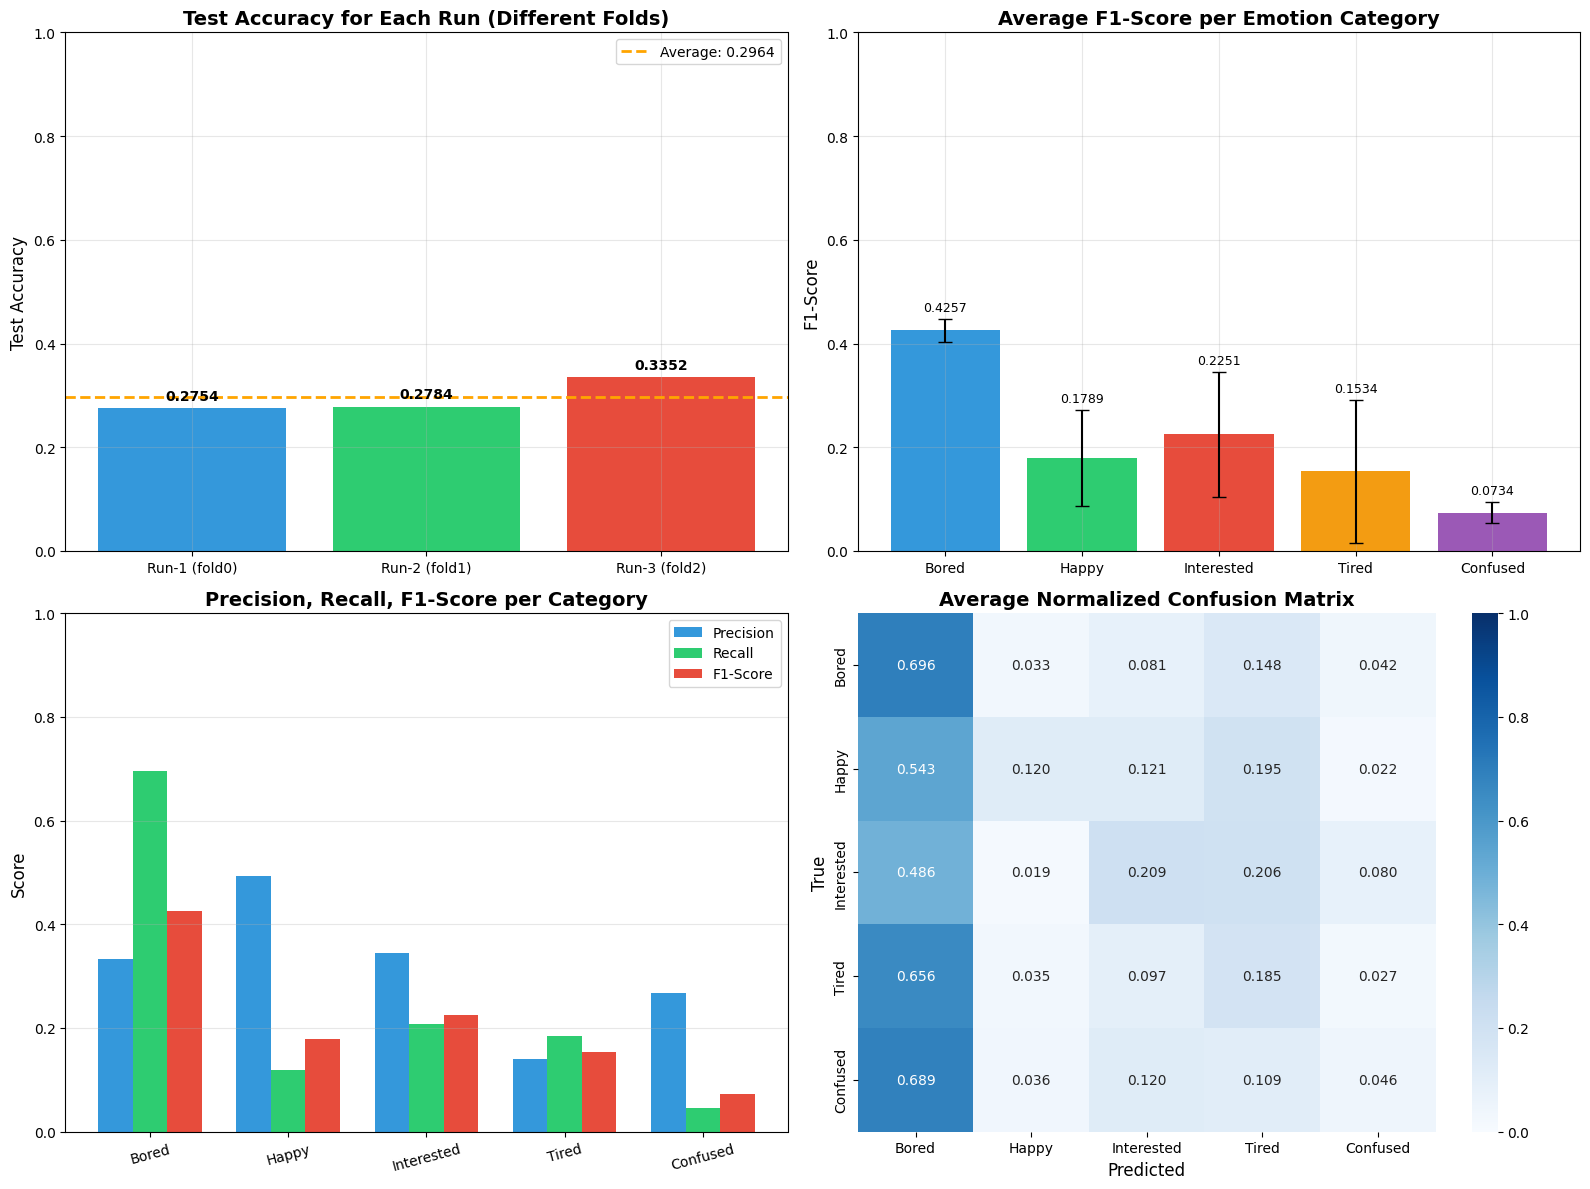

In [86]:
# ========== 创建可视化 ==========
print("\n正在生成可视化图表...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1: 每次运行的测试准确率
ax1 = axes[0, 0]
runs = [r['name'] for r in all_results]
test_accs = [r['test_acc'] for r in all_results]
bars = ax1.bar(runs, test_accs, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.axhline(y=avg_test_acc, color='orange', linestyle='--', linewidth=2, label=f'Average: {avg_test_acc:.4f}')
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy for Each Run (Different Folds)', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(True, alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 子图2: 每个类别的平均 F1-score
ax2 = axes[0, 1]
avg_f1_scores = [np.mean(class_metrics[label]['f1-score']) for label in class_labels]
std_f1_scores = [np.std(class_metrics[label]['f1-score']) for label in class_labels]
bars = ax2.bar(class_labels, avg_f1_scores, yerr=std_f1_scores, capsize=5,
               color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_title('Average F1-Score per Emotion Category', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)
for bar, f1, std in zip(bars, avg_f1_scores, std_f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
             f'{f1:.4f}', ha='center', va='bottom', fontsize=9)

# 子图3: 每个类别的 Precision, Recall, F1 对比
ax3 = axes[1, 0]
x = np.arange(len(class_labels))
width = 0.25
avg_precisions = [np.mean(class_metrics[label]['precision']) for label in class_labels]
avg_recalls = [np.mean(class_metrics[label]['recall']) for label in class_labels]
avg_f1s = [np.mean(class_metrics[label]['f1-score']) for label in class_labels]

bars1 = ax3.bar(x - width, avg_precisions, width, label='Precision', color='#3498db')
bars2 = ax3.bar(x, avg_recalls, width, label='Recall', color='#2ecc71')
bars3 = ax3.bar(x + width, avg_f1s, width, label='F1-Score', color='#e74c3c')

ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Precision, Recall, F1-Score per Category', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(class_labels, rotation=15)
ax3.legend()
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')

# 子图4: 平均混淆矩阵（归一化）
ax4 = axes[1, 1]
# 计算归一化的平均混淆矩阵
avg_cm_normalized = np.zeros((len(class_labels), len(class_labels)))
for result in all_results:
    cm = confusion_matrix(result['test_labels'], result['predictions'])
    # 归一化（按行，即每个真实类别的总数）
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    avg_cm_normalized += cm_normalized
avg_cm_normalized = avg_cm_normalized / len(all_results)

sns.heatmap(avg_cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax4,
            vmin=0, vmax=1)
ax4.set_xlabel('Predicted', fontsize=12)
ax4.set_ylabel('True', fontsize=12)
ax4.set_title('Average Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./data2025/reshb3fold/V_CNNLSTM_openface_average_results.png', dpi=300, bbox_inches='tight')
print(f"✓ 图表已保存至: ./data2025/reshb3fold/V_CNNLSTM_openface_average_results.png")
plt.show()

In [87]:
# ========== 保存结果到CSV ==========
print("\n正在保存结果到CSV文件...")

# 创建汇总表格
summary_data = []
for label in class_labels:
    summary_data.append({
        'Emotion': label,
        'Precision_mean': np.mean(class_metrics[label]['precision']),
        'Precision_std': np.std(class_metrics[label]['precision']),
        'Recall_mean': np.mean(class_metrics[label]['recall']),
        'Recall_std': np.std(class_metrics[label]['recall']),
        'F1-Score_mean': np.mean(class_metrics[label]['f1-score']),
        'F1-Score_std': np.std(class_metrics[label]['f1-score']),
        'Support_avg': np.mean(class_metrics[label]['support'])
    })

# 添加平均行
total_test_samples = sum([len(r['test_labels']) for r in all_results]) / len(all_results)
summary_data.append({
    'Emotion': 'macro avg',
    'Precision_mean': np.mean(macro_metrics['precision']),
    'Precision_std': np.std(macro_metrics['precision']),
    'Recall_mean': np.mean(macro_metrics['recall']),
    'Recall_std': np.std(macro_metrics['recall']),
    'F1-Score_mean': np.mean(macro_metrics['f1-score']),
    'F1-Score_std': np.std(macro_metrics['f1-score']),
    'Support_avg': total_test_samples
})

summary_data.append({
    'Emotion': 'weighted avg',
    'Precision_mean': np.mean(weighted_metrics['precision']),
    'Precision_std': np.std(weighted_metrics['precision']),
    'Recall_mean': np.mean(weighted_metrics['recall']),
    'Recall_std': np.std(weighted_metrics['recall']),
    'F1-Score_mean': np.mean(weighted_metrics['f1-score']),
    'F1-Score_std': np.std(weighted_metrics['f1-score']),
    'Support_avg': total_test_samples
})

df = pd.DataFrame(summary_data)
csv_path = './data2025/reshb3fold/V_CNNLSTM_openface_average_metrics.csv'
df.to_csv(csv_path, index=False, float_format='%.4f')
print(f"CSV文件已保存至: {csv_path}")

# 显示表格
print("\n结果表格:")
display(df)

# 额外保存每个 fold 的详细结果
print("\n保存每个 fold 的详细结果...")
fold_details = []
for result in all_results:
    fold_details.append({
        'Fold': result['fold'],
        'Run': result['name'],
        'Test_ACC': result['test_acc'],
        'Macro_Precision': result['report']['macro avg']['precision'],
        'Macro_Recall': result['report']['macro avg']['recall'],
        'Macro_F1': result['report']['macro avg']['f1-score'],
        'Weighted_Precision': result['report']['weighted avg']['precision'],
        'Weighted_Recall': result['report']['weighted avg']['recall'],
        'Weighted_F1': result['report']['weighted avg']['f1-score'],
        'Test_Samples': len(result['test_labels'])
    })

df_details = pd.DataFrame(fold_details)
details_path = './data2025/reshb3fold/V_CNNLSTM_openface_fold_details.csv'
df_details.to_csv(details_path, index=False, float_format='%.4f')
print(f"每个 fold 的详细结果已保存至: {details_path}")
print("\nFold 详细结果:")
display(df_details)

print("\n" + "="*70)
print("分析完成！")
print("="*70)
print("\n生成的文件：")
print(f"1. 平均指标: {csv_path}")
print(f"2. Fold 详细结果: {details_path}")
print(f"3. 可视化图表: ./data2025/reshb3fold/V_CNNLSTM_openface_average_results.png")


正在保存结果到CSV文件...
CSV文件已保存至: ./data2025/reshb3fold/V_CNNLSTM_openface_average_metrics.csv

结果表格:


,Emotion,Precision_mean,Precision_std,Recall_mean,Recall_std,F1-Score_mean,F1-Score_std,Support_avg
0,Bored,0.333558,0.076933,0.696005,0.202525,0.425714,0.021890,47.666667
1,Happy,0.493651,0.182795,0.119659,0.063038,0.178932,0.092262,28.666667
2,Interested,0.344807,0.021554,0.208562,0.150993,0.225103,0.120222,32.000000
3,Tired,0.139824,0.108893,0.185159,0.190591,0.153439,0.137362,37.000000
4,Confused,0.266667,0.169967,0.046062,0.014607,0.073416,0.020136,28.666667
5,macro avg,0.315701,0.040633,0.251089,0.034984,0.211321,0.061403,174.000000
6,weighted avg,0.309240,0.044745,0.296351,0.027494,0.233554,0.064438,174.000000



保存每个 fold 的详细结果...
每个 fold 的详细结果已保存至: ./data2025/reshb3fold/V_CNNLSTM_openface_fold_details.csv

Fold 详细结果:


,Fold,Run,Test_ACC,Macro_Precision,Macro_Recall,Macro_F1,Weighted_Precision,Weighted_Recall,Weighted_F1,Test_Samples
0,0,Run-1 (fold0),0.275449,0.261930,0.218386,0.131629,0.253440,0.275449,0.152868,167
1,1,Run-2 (fold1),0.278409,0.325037,0.235290,0.221294,0.311294,0.278409,0.237211,176
2,2,Run-3 (fold2),0.335196,0.360137,0.299592,0.281040,0.362985,0.335196,0.310582,179



分析完成！

生成的文件：
1. 平均指标: ./data2025/reshb3fold/V_CNNLSTM_openface_average_metrics.csv
2. Fold 详细结果: ./data2025/reshb3fold/V_CNNLSTM_openface_fold_details.csv
3. 可视化图表: ./data2025/reshb3fold/V_CNNLSTM_openface_average_results.png
